# Setup the Environment
We are going to use YOLOv5 model for training/testing/validation.
<br>
So we clone and install the YOLOv5 from Github.
<br>
We also verify that there is a GPU for training.


In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd /content/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14998, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14998 (delta 0), reused 1 (delta 0), pack-reused 14995
Receiving objects: 100% (14998/14998), 14.03 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (10286/10286), done.
/content/yolov5


In [2]:
!pip install -qr requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.2 MB/s eta 0:00:00


In [3]:
cd /content/yolov5

/content/yolov5


In [4]:
# Import required libraries

import os
import glob
import torch
import cv2
import warnings
import zipfile
import PIL.Image

import pandas as pd
import numpy  as np
import xml.etree.ElementTree as ET 
import matplotlib.pyplot     as plt
import seaborn               as sns

from datetime                import datetime
from sklearn.model_selection import train_test_split
from google.colab            import drive
from IPython.display         import Image, clear_output

warnings.filterwarnings('ignore')

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU.'))

input_data  = '/tmp/data/input'
output_data = '/tmp/data/output'

Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Download Dataset
Read the data from .xml files
<br>
Extract filename and dimensions of the bouding boxes
<br>
and import that data into a pandas DataFrame

In [5]:
drive.mount('/content/gdrive')

zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp')                                         #Extracts the files into the /tmp folder
zip_ref.close()

Mounted at /content/gdrive


In [6]:
annotations_path = "/tmp/data/input/annotations"
images_path      = "/tmp/data/input/images"

dataset = {
            "file":  [],
            "name":  [],    
            "width": [],
            "height":[],
            "xmin":  [],
            "ymin":  [],   
            "xmax":  [],
            "ymax":  [],
           }

for anno in glob.glob(annotations_path + "/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    # We consider that a mask not weared correctly is the same as not wearing a mask
                    if attr.text == 'mask_weared_incorrect':
                        attr.text = 'without_mask'

                    name = attr.text                 
                    dataset['name']   += [name]
                    dataset['width']  += [width]
                    dataset['height'] += [height] 
                    dataset['file']   += [anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin'] += [ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax'] += [xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax'] += [ymax]

In [7]:
df=pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss526,without_mask,400,263,66,30,100,66
1,maksssksksss526,with_mask,400,263,165,85,200,120
2,maksssksksss526,with_mask,400,263,251,88,285,123
3,maksssksksss526,without_mask,400,263,309,107,350,146
4,maksssksksss209,without_mask,400,210,37,50,63,78


In [8]:
name_dict = {
    'with_mask'   : 0,
    'without_mask': 1
}

df['class'] = df['name'].map(name_dict)
np.sort(df.name.unique())

array(['with_mask', 'without_mask'], dtype=object)

# Train,Test and Val Split
Split the dataset into training testing and validation set
<br>
separate the data in different folder inside the Yolo directory
<br>
and Normalize data

In [9]:
fileNames = [*os.listdir("/tmp/data/input/images")]
print('There are {} images in the dataset'.format(len(fileNames)))

There are 853 images in the dataset


In [10]:
train, test = train_test_split(fileNames, test_size = 0.1, random_state = 22)
test,  val  = train_test_split(test,      test_size = 0.7, random_state = 22)

print("Length of Train =", len(train))
print("=" *30 )
print("Length of Valid =", len(val))
print("=" *30 )
print("Length of test =",  len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [11]:
# create separate train test and validation directories inside /content/yolov5/data/
os.mkdir('/content/yolov5/data/train')
os.mkdir('/content/yolov5/data/val')
os.mkdir('/content/yolov5/data/test')
os.mkdir('/content/yolov5/data/train/images')
os.mkdir('/content/yolov5/data/train/labels')
os.mkdir('/content/yolov5/data/test/images')
os.mkdir('/content/yolov5/data/test/labels')
os.mkdir('/content/yolov5/data/val/images')
os.mkdir('/content/yolov5/data/val/labels')

In [12]:
# pass the images from the unzipped file to the folders inside yolov5
def copyImages(imageList, folder_Name):
    
    for image in imageList:
        img  = PIL.Image.open(input_data + "/images/" + image)
        img1 = img.resize((640, 480))
        _ = img1.save("/content/yolov5/data/" + folder_Name + "/images/" + image)

copyImages(train, "train")
copyImages(val,   "val")
copyImages(test,  "test")

In [13]:
# Resizing the images
df['xmin'] = (640/df['width'])  * df['xmin']
df['xmax'] = (640/df['width'])  * df['xmax']

df['ymin'] = (480/df['height']) * df['ymin']
df['ymax'] = (480/df['height']) * df['ymax']

df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

df['x_center'] = (df['xmax']+df['xmin']) / (2*640)
df['y_center'] = (df['ymax']+df['ymin']) / (2*480)

df['box_height'] = (df['xmax']-df['xmin']) / (640)
df['box_width']  = (df['ymax']-df['ymin']) / (480)

df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss526,without_mask,400,263,105,54,160,120,1,0.207031,0.181250,0.085938,0.137500
1,maksssksksss526,with_mask,400,263,264,155,320,219,0,0.456250,0.389583,0.087500,0.133333
2,maksssksksss526,with_mask,400,263,401,160,456,224,0,0.669531,0.400000,0.085938,0.133333
3,maksssksksss526,without_mask,400,263,494,195,560,266,1,0.823438,0.480208,0.103125,0.147917
4,maksssksksss209,without_mask,400,210,59,114,100,178,1,0.124219,0.304167,0.064062,0.133333


In [14]:
df = df.astype('string')
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss526,without_mask,400,263,105,54,160,120,1,0.20703125,0.18125,0.0859375,0.1375
1,maksssksksss526,with_mask,400,263,264,155,320,219,0,0.45625,0.38958333333333334,0.0875,0.13333333333333333
2,maksssksksss526,with_mask,400,263,401,160,456,224,0,0.66953125,0.4,0.0859375,0.13333333333333333
3,maksssksksss526,without_mask,400,263,494,195,560,266,1,0.8234375,0.48020833333333335,0.103125,0.14791666666666667
4,maksssksksss209,without_mask,400,210,59,114,100,178,1,0.12421875,0.30416666666666664,0.0640625,0.13333333333333333


In [15]:
# Using each image bounding box values to create labels
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]
    
    for name in fileNames:
        data = df[df.file == name]
        box_list = []
      
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class'] + " " + row["x_center"] + " " + row["y_center"] + " " + row["box_height"] + " " + row["box_width"])
            
        text = "\n".join(box_list)
        
        with open("/content/yolov5/data/" + data_name + "/labels/" + name + ".txt", "w") as file:
            file.write(text)


create_labels(train, "train")
create_labels(val,   "val")
create_labels(test,  "test")

# Configure the Model

In [16]:
# go to YOLO directory
%cd /content/yolov5
from yolov5 import utils
display = utils.notebook_init()


YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.6/78.2 GB disk)


In [17]:
# configure data.yaml file to guide the model for training

yaml_text = """train: /content/yolov5/data/train/images
val: /content/yolov5/data/val/images
test: /content/yolov5/data/test/images

nc: 2
names: ['with_mask','without_mask']"""

with open("./data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [18]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [19]:
%%writetemplate /content/yolov5/models/custom_yolov5l.yaml

# Parameters
nc: 2  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


# Training

In [ ]:
# train yolov5l on custom data for 100 epochs
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 16 --epochs 100 --data /content/yolov5/data/data.yaml --cfg /content/yolov5/models/custom_yolov5l.yaml --weights '' --name yolov5l_results  

/content/yolov5
train: weights=, cfg=/content/yolov5/models/custom_yolov5l.yaml, data=/content/yolov5/data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5l_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-63-gcdd804d Python-3.8.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=

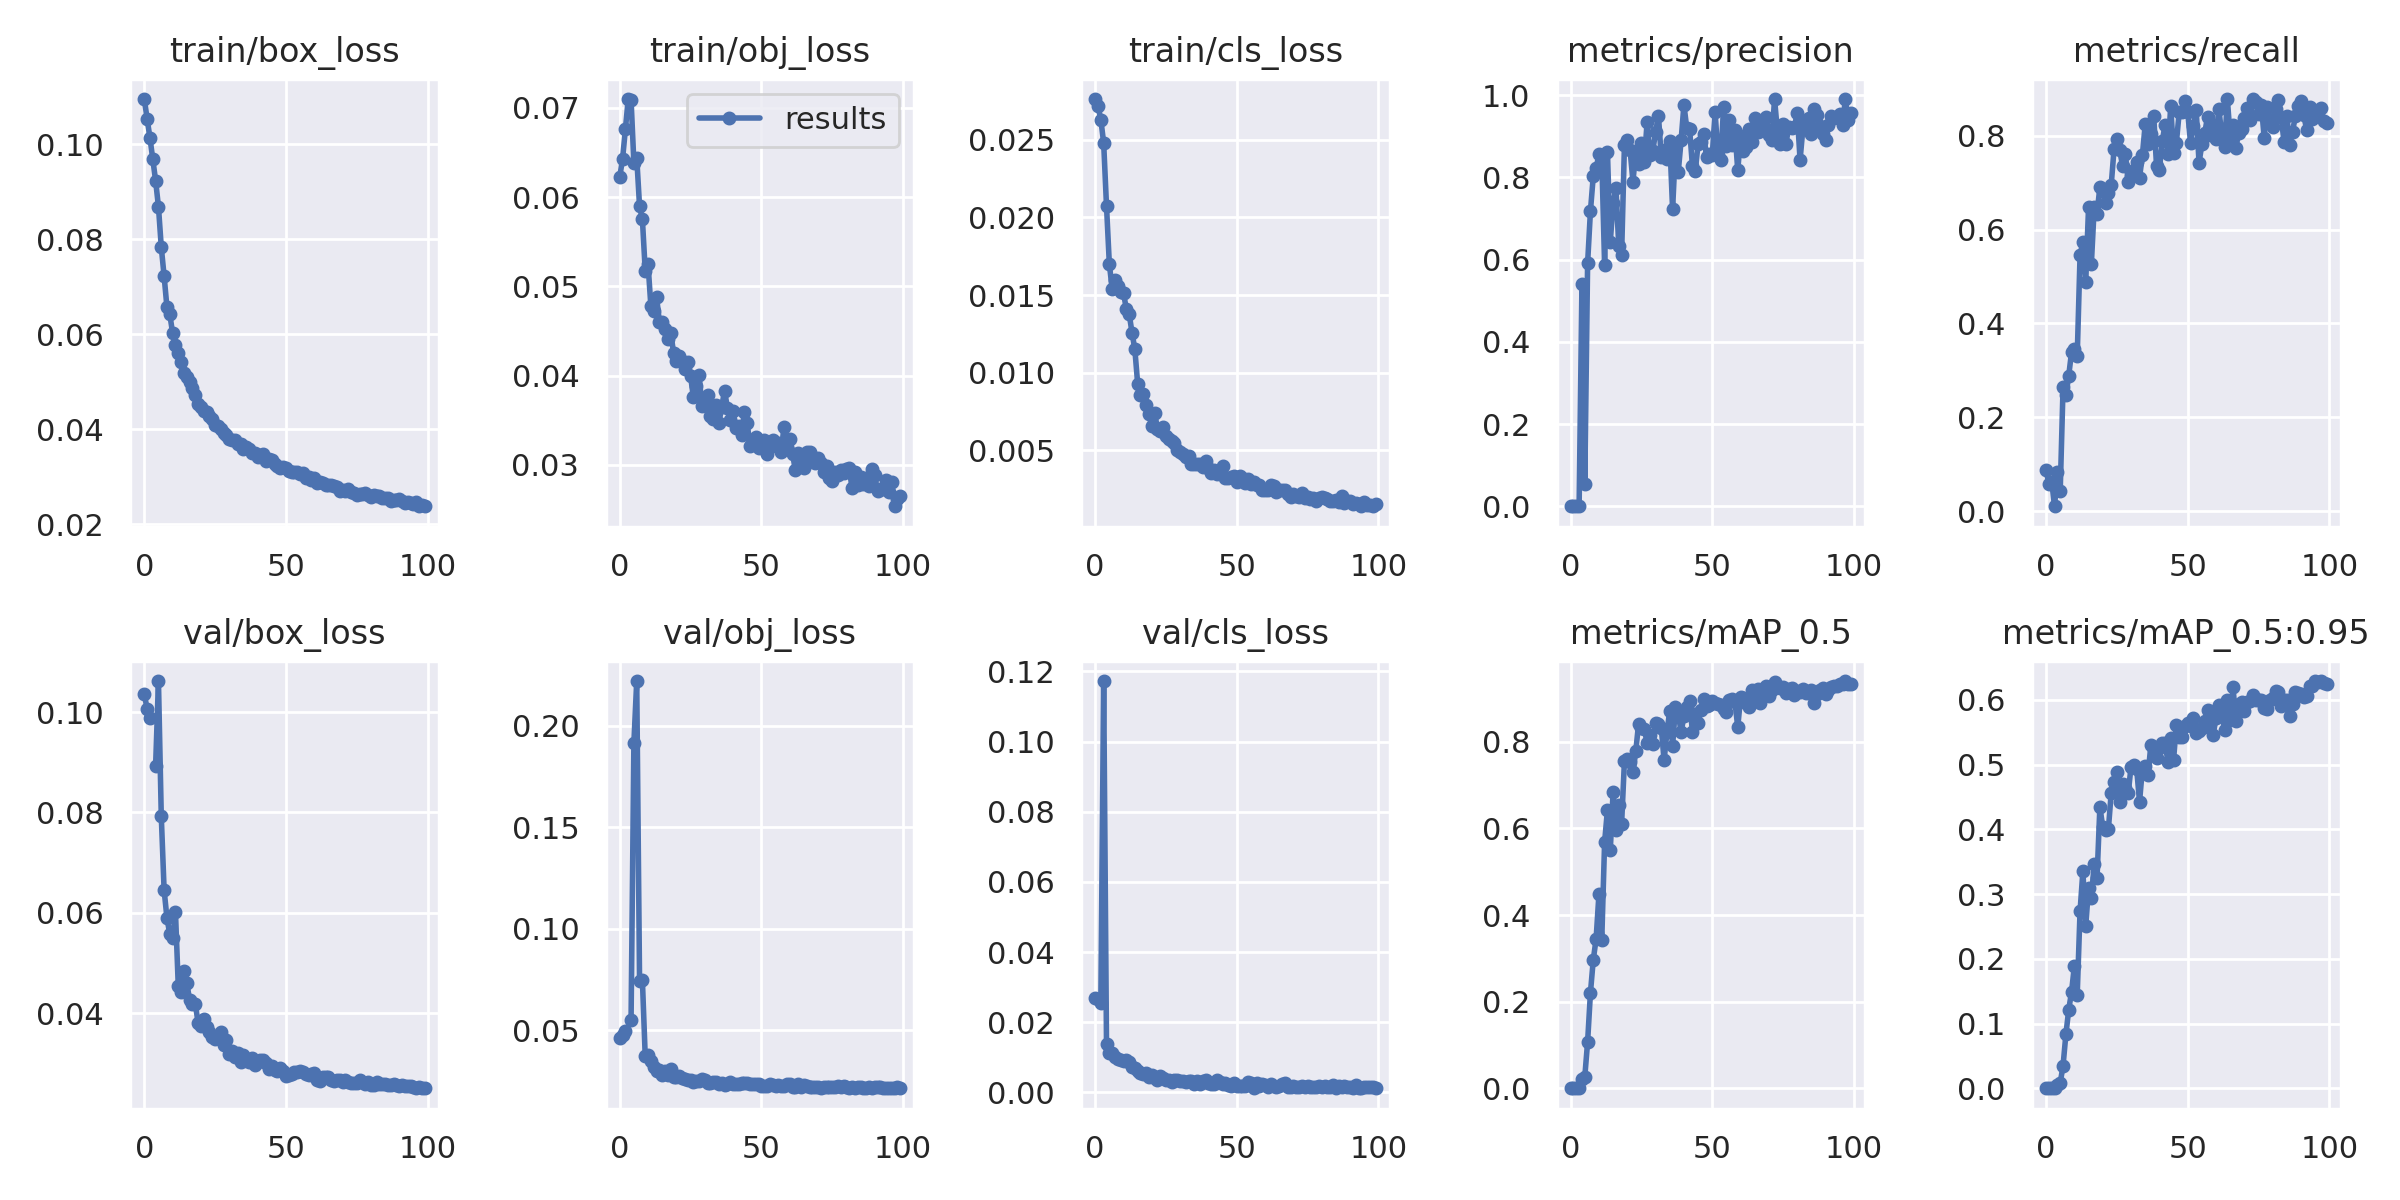

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5l_results/results.png', width=1000)  # view results.png

# Validation 

In [ ]:
%%time
%cd /content/yolov5/
!python val.py --img 640 --batch 16 --data /content/yolov5/data/data.yaml --weights runs/train/yolov5l_results/weights/best.pt --name 'Validation' 

/content/yolov5
val: data=/content/yolov5/data/data.yaml, weights=['runs/train/yolov5l_results/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=Validation, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-63-gcdd804d Python-3.8.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /content/yolov5/data/val/labels.cache... 61 images, 0 backgrounds, 0 corrupt: 100% 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:04<00:00,  1.01s/it]
                   all         61        265      0.991      0.858       0.94      0.631
             with_mask         61        239      0.981      0.869      

# Testing
lets test the model over test images we had separated before training

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

val/


In [ ]:
# use the best weights
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5l_results/weights/best.pt --img 640 --conf 0.4 --source /content/yolov5/data/test/images

/content/yolov5
detect: weights=['runs/train/yolov5l_results/weights/best.pt'], source=/content/yolov5/data/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-63-gcdd804d Python-3.8.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
image 1/25 /content/yolov5/data/test/images/maksssksksss168.png: 480x640 2 with_masks, 2 without_masks, 43.1ms
image 2/25 /content/yolov5/data/test/images/maksssksksss183.png: 480x640 2 with_masks, 1 without_mask, 40.1ms
image 3/25 /content/yolov5/data/test/images/maksssksksss236.png: 480x640 1 

# Pre Trained Weights

In [ ]:
# Validation with pre trained weights
%%time
%cd /content/yolov5/
!python val.py --img 640 --batch 16 --data /content/yolov5/data/data.yaml --weights /content/gdrive/MyDrive/bestL.pt --name 'Validation' 

/content/yolov5
val: data=/content/yolov5/data/data.yaml, weights=['/content/gdrive/MyDrive/bestL.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=Validation, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-63-gcdd804d Python-3.8.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /content/yolov5/data/val/labels.cache... 61 images, 0 backgrounds, 0 corrupt: 100% 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:04<00:00,  1.05s/it]
                   all         61        265      0.991      0.858       0.94      0.631
             with_mask         61        239      0.981      0.869      0.966     

In [20]:
#Test with pre trained weights
%cd /content/yolov5/
!python detect.py --weights /content/gdrive/MyDrive/bestL.pt --img 640 --conf 0.4 --source /content/yolov5/data/test/images --save-conf

/content/yolov5
detect: weights=['/content/gdrive/MyDrive/bestL.pt'], source=/content/yolov5/data/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
image 1/25 /content/yolov5/data/test/images/maksssksksss117.png: 480x640 1 with_mask, 42.9ms
image 2/25 /content/yolov5/data/test/images/maksssksksss129.png: 480x640 1 with_mask, 2 without_masks, 37.1ms
image 3/25 /content/yolov5/data/test/images/maksssksksss161.png: 480x640 1 without_mask, 37.1ms
image 4/

#Results

In [21]:
color_dict = {
    'with_mask'    : (0, 255, 0),
    "without_mask" : (255, 0, 0)
}

In [22]:
def show_image(img_id):
    
    df_image = df[df.file == img_id.split(".")[0] ]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = '/content/yolov5/data/test/images/'+img_id
    img = plt.imread(path)

    imge = img.copy()
    
    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('/content/yolov5/runs/detect/exp/'+img_id)

    plt.figure(figsize=(14,17))
    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

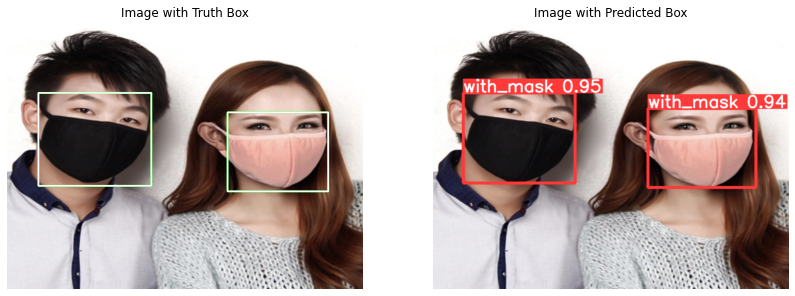

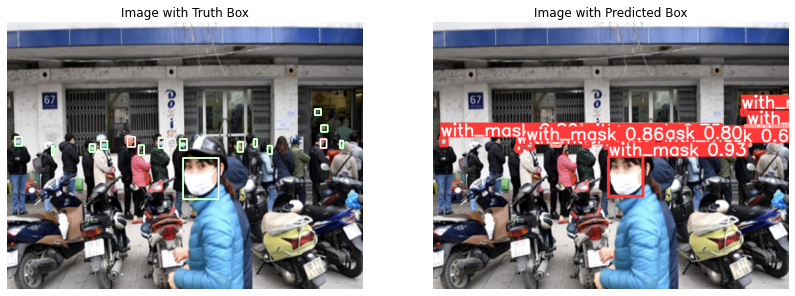

In [23]:
import os, random
show_image(random.choice(os.listdir("/content/yolov5/data/test/images"))) 
show_image(random.choice(os.listdir("/content/yolov5/data/test/images"))) 
plt.show()

# Export weights to Google Drivefor future runs

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cp /content/yolov5/runs/train/yolov5l_results/weights/best.pt /content/gdrive/My\ Drive

# END